[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/intro_to_sparse_data_and_embeddings.ipynb)

# 嵌套(Embedding)

嵌套是一种相对低维的空间，你可以将高维矢量映射到这种低维空间里。通过使用嵌套，可以让大型输入(比如代表字词的稀疏矢量)上进行机器学习变得更加容易。在理想情况下，嵌套可以将语义上相似的不同输入映射到嵌套空间里的邻近处，以此来捕获输入的语义。一个模型学习到的嵌套，也可以被其他模型重用。

学习目标：
- 学习嵌套的定义和用途
- 学习嵌套如何编码语义关系
- 学习如何使用嵌套
- 学习如何训练有意义的嵌套(例如使用word2vec)

## 嵌套：协同过滤的目的

协同过滤是一项可以预测用户兴趣(根据很多其他用户的兴趣)的任务。以影片推荐的任务为例，假设我们有100万个用户，以及每位用户观看过的影片的列表(可供观看的影片共有50万部)。我们的目标是向用户推荐影片。

要解决这个问题，我们需要**使用某种方法来确定哪些影片是相似的**。我们可以**通过影片嵌套到低维空间(使得相似影片彼此邻近)来实现这个目标**。

在介绍如何学习嵌套之前，我们先来了解一下我们希望嵌套具备的特质类型，以及我们将如何表示训练数据以供学习嵌套。

## 嵌套：分类输入数据
分类数据是指用于表示一组有限选项中的一个或多个离散项的输入特征。例如，它可以是某用户观看过的一组影片，某文档中使用的一系列单词，或某人从事的职业。

分类数据的最高效表示方法是使用稀疏张量(一种含有极少非0元素的张量)。例如，如果要构建一个影片推荐模型，可以为每部可能的影片分别分配一个唯一的ID，然后通过用户已观看影片的稀疏张量来表示每位用户。

为了能够在机器学习系统中使用这类表示法，我们需要将每个稀疏矢量表示为数字矢量，从而**使语义上相似的项(影片或字词)在矢量空间中具有相似的距离**。但如何将字词表示为数字矢量呢？

最简单的方法是：定义一个巨型输入层，并在其中为词汇表内的每个字词设定一个节点，或者至少为数据中出现的每个字词设定一个节点。如果数据中出现了50万个独一无二的单词，你可以使用长度为50万的矢量来表示每个单词，并将每个字词分配到相应矢量中对应的索引位置。

这里我们可以通过独热编码或者词袋模型来达到以上的目的。

不过，无论你如何确定非0值，若将节点与字词一一对应，你得到的输入矢量就会比较稀疏。即：矢量很大，但非0值相对较少。稀疏表示法存在多项问题(如下所述)，这些问题可能会致使模型很难高效地学习。

### 网络的规模
巨型输入矢量意味着神经网络的对应权重数目会极其庞大。如果你的词汇表内有M个字词，而神经网络输入层上方的第一层内有N个节点，你便需要为该层训练MxN个权重。权重数目过大会进一步引发以下问题：

- 数据量： 模型中的权重越多，高效训练所需的数据就越多
- 计算量：权重越多，训练和使用模型所需的计算就越多。这很容易就会超出你硬件的能力范围。

### 矢量之间缺乏有意义的联系
如果将RGB通道的像素值馈入到图片分类器中，分析“邻近”值便行得通。不管是从语义上来看，还是从矢量之间的几何距离来看，红蓝色和纯蓝色都是邻近的。不过，对于在索引1247处设为1以表示“马”的矢量而言，如果说它与在索引238处设为1以表示“电视机”的矢量不够邻近，那么它与在索引50430处设为1以表示羚羊的矢量亦然。

### 解决方案：嵌套
上述问题的解决方案就是使用嵌套，也就是将大型稀疏矢量映射到一个保留语义关系的低维空间。在此模块的随后几个部分中，我们将从直观角度、概念角度和编程角度来详细探讨嵌套。

## 嵌套：转换到低维空间
要解决稀疏输入数据的核心问题，你可以将高维数据映射到低纬度空间。

通过之上练习你已了解，即便是小型多维空间，也能自由的将语义上相似的项归到一起，并将相异项分开。矢量空间中的位置(距离和方向)可对良好的嵌套中的语义进行编码。例如，下面的真实嵌套可视化图所展示的几何关系图捕获了国家与其首都之间的语义关系。

### 收缩网络
尽管我们需要足够的维度来编码丰富的语义关系，但我们也需要足够小的嵌套空间来更快速的训练我们的系统。**实用嵌套的量级大致有数百个维度**。这可能比你在自然语言任务中使用的词汇规模小好几个数量级。

### 嵌套充当查询表
嵌套是一个矩阵，每列表示词汇中的一项所对应的矢量。要获得某个词汇项的密集矢量，你可以检索该项所对应的列。

但是，如何转换字词矢量的稀疏包呢？要获得表示多个词汇项(例如，一句或一段中的所有字词)的稀疏矢量的密集矢量，你可以检索各项的嵌套，然后将它们相加。

如果稀疏矢量包含词汇项的计数，则你可以将每项嵌套与其对应项的计数相乘，然后再求和。

#### 嵌套查询充当矩阵乘法
刚刚阐述的查询、乘法和加法过程等效于矩阵乘法。假如有一个1xN的稀疏表示S和一个NxM的嵌套表E，矩阵乘法SxE可以得出密集矢量1xM。

但首要问题是，如何获取E呢？我们将在下一部分介绍如何获取嵌套。

## 嵌套：获取嵌套
你可以通过多种方式来获取嵌套，包括google研发的世界一流算法。

### 标准降维技术
目前有很多在低维空间捕获高维空间重要结构的数学技术。理论上，这些技术都可以用来创建用于机器学习系统的嵌套。

例如，[主成分分析](https://en.wikipedia.org/wiki/Principal_component_analysis)(PCA)已用于创建字词嵌套。在给定一组实例的情况下，例如字词矢量包，PCA会尝试查找高度相关且可以合并的维度。

### word2vec
word2vec是google为了训练字词嵌套而研发的一种算法。**word2vec基于分布假设，将语义上相似的字词映射到在集合图形上邻近的嵌套矢量**。

**分布假设指出经常具有相同相邻字词的字词往往在语义上相似**。“狗”和“猫”这两个字词经常靠近“兽医”一词出现，这就可以说明这两个字词在语义上相似。正如语言学家约翰.弗斯在1957年所言：“观其伴而知其意”。

word2vec通过训练神经网络来区分实际共同出现的多组字词与随机出现在一起的字词，从而充分利用此类上下文信息。**输入层采用一种稀疏表示法用于组合一个目标字词与一个或多个上下文字词。这一输入层会连接到一个较小的隐藏层。**

在其中一版算法中，系统通过用随机噪点字词替代目标字词来举出反面示例。在给出正面示例"the plane flies"的情况下，系统可能会换成"jogging"来创建对比鲜明的反面示例"the jogging flies"。

另一版算法通过将真实的目标字词与随机选择的上下文字词配对来创建反面示例。因此，系统可能会举出正面示例((the plane)、(flies,plane))和反面示例((compiled,plane)、(who,plane))，然后通过学习分辨哪几对真正地在文字中一起出现。

不过，分类器不是上述任何一版算法的真正用途。在训练模型后，你得到的是一组嵌套。借助将输入层连接到隐藏层的权重，你可以将字词的稀疏表示映射到小型矢量。这类嵌套可在其他分类器中重复利用。

要详细了解word2vec，请参阅[TensorFlow.org上的教程](https://tensorflow.google.cn/tutorials/word2vec)

### 将嵌套训练为大型模型的一部分
你也可以将嵌套作为目标任务的神经网络的一部分进行学习。通过这个方法，你可以为自己的特定系统量身定制嵌套，不过耗费的时间可能要比单独训练嵌套的时间长。

一般来说，当你具有稀疏数据(或你想要嵌套的密集数据)时，你可以创建一个嵌套单元，这个嵌套单元其实是大小为d(在此练习中d=3，使用三维嵌入)的一个特殊类型的隐藏单元。此嵌套层可与任何其他特征和隐藏层组合。和任何DNN中一样，最终层将是要进行优化的损失函数。例如，假设我们正在执行协同过滤，**目标是根据其他用户的兴趣预测某位用户的兴趣**。我们可以**将这个问题作为监督式学习问题进行建模，具体做法是随机选取(或留出)用户观看过的一小部分影片作为正类别标签，然后再优化softmax损失**。

再举一个例子，如果你想在DNN中**针对房地产广告词创建嵌套层来预测房价**，则你可以将训练数据中的已知房屋售价用作标签来优化L2损失。

在学习d维嵌套是，每一项都会映射到d维空间中的一个点，这样相似项会在该空间内彼此邻近。在嵌套层中学到的权重和几何视图之间的关系。输入节点与d维嵌套层中的节点之间的边的权重对应于d为坐标轴中每一维的坐标值。

# 稀疏数据的嵌入简介

学习目标：
- 将影评字符串数据转换为稀疏特征矢量
- 使用稀疏特征矢量实现情感分析线性模型
- 通过将数据投射到二维空间的嵌入来实现情感分析DNN模型
- 将嵌入可视化，以便查看模型学到的词语之间的关系

在此练习中，我们将探讨稀疏数据，并使用影评文本数据(来自[ACL 2011IMDB数据集](http://ai.stanford.edu/~amaas/data/sentiment/))进行嵌入。这些数据已被处理成tf.example格式。

### 设置
我们导入依赖项并下载训练数据和测试数据。[tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)中包含一个文件下载和缓存工具，我们可以用它来检索数据集。

In [0]:
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

## 构建情感分析模型
我们根据这些数据训练一个情感分析模型，以预测某条件总体上是好评(标签为1)还是差评(标签为0)

为此，我们会使用词汇表(即我们预计将在数据中看到的每个术语的列表)，将字符串值terms转换为特征矢量。在本练习中，我们创建了侧重于一组有限术语的小型词汇表。其中的大多数术语明确表示是好评或差评，但有些只是因为有趣而被添加进来。

词汇表中的每个术语都与特征矢量中的一个坐标相对应。为了将样本的字符串值terms转换为这种矢量格式，我们按以下方式处理字符串值:如果该术语没有出现在样本字符串中，则坐标值将为0；如果出现在样本字符串中，则值为1.未出现在该词汇表中的样本中的术语将被弃用。

**注意:**我们当然可以使用更大的词汇表，而且有创建此类词汇表的专用工具。此外，我们可以添加少量的OOV(未收录词汇)分桶，你可以在其中对词汇表中为包含的术语进行哈希处理，而不仅仅是弃用这些术语。我们还可以使用特征哈希法对每个属于进行哈希处理，而不是创建显式词汇表。这在实践中很有效，但却不具备可解读性(这对本练习非常实用)。如需了解处理此类词汇表的工具，请参阅tf.feature_column模块。

## 构建输入管道

首先，我们来配置输入管道，以将数据导入TensorFlow模型中。我们可以使用以下函数来解析训练数据和测试数据(格式为[TFRecord](https://www.tensorflow.org/programmers_guide/datasets)),然后返回一个由特征和相应标签组成的字典。

In [0]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

为了确认函数是否能正常运行，我们为训练数据构建一个TFRecordDataset,并使用上述函数将数据映射到特征和标签

In [29]:
# Create the Dataset object
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [30]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

构建一个正式的输入函数，可以将其传递给TensorFlow Estimator对象的train方法

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

## 任务1：使用具有稀疏输入和显式词汇表的线性模型
对于我们的第一个模型，我们将使用54个信息性术语来构建LinearClassifier模型；始终从简单入手!

如果代码将为我们的术语构建特征列。categorical_column_with_vocabulary_list函数可使用"字符串-特征矢量"映射来创建特征列。

In [0]:
# 54 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family", "man", "woman", "boy", "girl")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

 接下来，我们将构建 `LinearClassifier`，在训练集中训练该模型，并在评估集中对其进行评估。阅读上述代码后，运行该模型以了解其效果。

In [33]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78784
accuracy_baseline 0.5
auc 0.8721849
auc_precision_recall 0.86474305
average_loss 0.45237985
label/mean 0.5
loss 11.309496
prediction/mean 0.47748864
global_step 1000
---
Test set metrics:
accuracy 0.78196
accuracy_baseline 0.5
auc 0.8691151
auc_precision_recall 0.86110735
average_loss 0.45535558
label/mean 0.5
loss 11.383889
prediction/mean 0.47653508
global_step 1000
---


 ## 任务 2：使用深度神经网络 (DNN) 模型

上述模型是一个线性模型，效果非常好。但是，我们可以使用 DNN 模型实现更好的效果吗？

我们将 `LinearClassifier` 切换为 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)。运行以下单元，看看您的模型效果如何。

In [34]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.76
accuracy_baseline 0.52
auc 0.8653846
auc_precision_recall 0.87309045
average_loss 0.42299554
label/mean 0.52
loss 10.574888
prediction/mean 0.56165934
global_step 1000
---
Test set metrics:
accuracy 0.8
accuracy_baseline 0.52
auc 0.9326922
auc_precision_recall 0.9469273
average_loss 0.32743737
label/mean 0.48
loss 8.185934
prediction/mean 0.52951944
global_step 1000
---


 ## 任务 3：在 DNN 模型中使用嵌入

在此任务中，我们将使用嵌入列来实现 DNN 模型。嵌入列会将稀疏数据作为输入，并返回一个低维度密集矢量作为输出。

 **注意**：*从计算方面而言，embedding_column 通常是用于在稀疏数据中训练模型最有效的选项。在此练习末尾的[可选部分](#scrollTo=XDMlGgRfKSVz)，我们将更深入地讨论使用 `embedding_column` 与 `indicator_column` 之间的实现差异，以及如何在这两者之间做出权衡。*
 
  在下面的代码中，执行以下操作：

* 通过将数据投射到二维空间的 `embedding_column` 来为模型定义特征列（如需详细了解 `embedding_column` 的函数签名，请参阅相关 [TF 文档](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)）。
* 定义符合以下规范的 `DNNClassifier`：
  * 具有两个隐藏层，每个包含 20 个单元
  * 采用学习速率为 0.1 的 AdaGrad 优化方法
  * `gradient_clip_norm 值为 5.0`
  
   **注意**：*在实践中，我们可能会将数据投射到 2 维以上（比如 50 或 100）的空间中。但就目前而言，2 维是比较容易可视化的维数。*

In [35]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78512
accuracy_baseline 0.5
auc 0.8677023
auc_precision_recall 0.8561443
average_loss 0.45566544
label/mean 0.5
loss 11.391636
prediction/mean 0.5173293
global_step 1000
---
Test set metrics:
accuracy 0.78104
accuracy_baseline 0.5
auc 0.86676204
auc_precision_recall 0.85495603
average_loss 0.45669115
label/mean 0.5
loss 11.417278
prediction/mean 0.5160941
global_step 1000
---


 ## 任务 4：确信模型中确实存在嵌入

上述模型使用了 `embedding_column`，而且似乎很有效，但这并没有让我们了解到内部发生的情形。我们如何检查该模型确实在内部使用了嵌入？

首先，我们来看看该模型中的张量：

In [36]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

 好的，我们可以看到这里有一个嵌入层：`'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`。（顺便说一下，有趣的是，该层可以与模型的其他层一起训练，就像所有隐藏层一样。）

嵌入层的形状是否正确？请运行以下代码来查明。

 **注意**：*在我们的示例中，嵌入是一个矩阵，可让我们将一个 54 维矢量投射到 2 维空间。*

In [37]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(54, 2)

 花些时间来手动检查各个层及其形状，以确保一切都按照您预期的方式互相连接。
 
  ## 任务 5：检查嵌入

现在，我们来看看实际嵌入空间，并了解术语最终所在的位置。请执行以下操作：
1. 运行以下代码来查看我们在**任务 3** 中训练的嵌入。一切最终是否如您所预期的那样？

2. 重新运行**任务 3** 中的代码来重新训练该模型，然后再次运行下面的嵌入可视化。哪些保持不变？哪些发生了变化？

3. 最后，仅使用 10 步来重新训练该模型（这将产生一个糟糕的模型）。再次运行下面的嵌入可视化。您现在看到了什么？为什么？

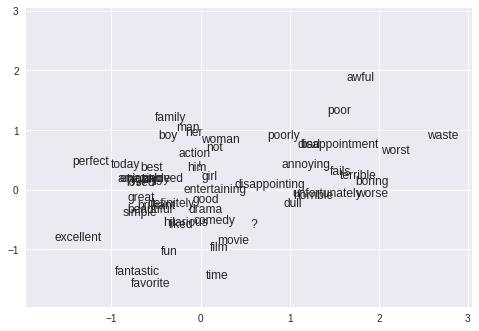

In [38]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0's everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little set-up to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (12, 12)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

 ## 任务 6：尝试改进模型的效果

看看您能否优化该模型以改进其效果。您可以尝试以下几种做法：

* **更改超参数**或**使用其他优化工具**，比如 Adam（通过遵循这些策略，您的准确率可能只会提高一两个百分点）。
* **向 `informative_terms` 中添加其他术语。**此数据集有一个完整的词汇表文件，其中包含 30716 个术语，您可以在以下位置找到该文件：https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt 您可以从该词汇表文件中挑选出其他术语，也可以通过 `categorical_column_with_vocabulary_file` 特征列使用整个词汇表文件。

In [39]:
!wget https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt -O /tmp/terms.txt

--2018-04-28 08:05:44--  https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253538 (248K) [text/plain]
Saving to: ‘/tmp/terms.txt’

/tmp/terms.txt      100%[===================>] 247.60K  --.-KB/s    in 0.004s  

2018-04-28 08:05:44 (66.5 MB/s) - ‘/tmp/terms.txt’ saved [253538/253538]



In [41]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with open("/tmp/terms.txt", 'r') as f:
  # Convert it to set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.79976
accuracy_baseline 0.5
auc 0.8821446
auc_precision_recall 0.87790227
average_loss 0.4388096
label/mean 0.5
loss 10.970241
prediction/mean 0.5401165
global_step 1000
---
Test set metrics:
accuracy 0.78872
accuracy_baseline 0.5
auc 0.86893976
auc_precision_recall 0.8645288
average_loss 0.45835477
label/mean 0.5
loss 11.458869
prediction/mean 0.5344713
global_step 1000
---


 ## 总结

我们可能获得了比我们原来的线性模型更好且具有嵌入的 DNN 解决方案，但线性模型也相当不错，而且训练速度快得多。线性模型的训练速度之所以更快，是因为它们没有太多要更新的参数或要反向传播的层。

在有些应用中，线性模型的速度可能非常关键，或者从质量的角度来看，线性模型可能完全够用。在其他领域，DNN 提供的额外模型复杂性和能力可能更重要。在定义模型架构时，请记得要充分探讨您的问题，以便知道自己所处的情形。

 ### *可选内容：*在 `embedding_column` 与 `indicator_column` 之间进行权衡

从概念上讲，在训练 `LinearClassifier` 或 `DNNClassifier` 时，需要根据实际情况使用稀疏列。TF 提供了两个选项：`embedding_column` 或 `indicator_column`。

在训练 LinearClassifier（如**任务 1** 中所示）时，系统在后台使用了 `embedding_column`。正如**任务 2** 中所示，在训练 `DNNClassifier` 时，您必须明确选择 `embedding_column` 或 `indicator_column`。本部分通过一个简单的示例讨论了这两者之间的区别，以及如何在二者之间进行权衡。

 假设我们的稀疏数据包含 `"great"`、`"beautiful"` 和 `"excellent"` 这几个值。由于我们在此处使用的词汇表大小为 $V = 54$，因此第一层中的每个单元（神经元）的权重将为 54。我们用 $s$ 表示稀疏输入中的项数。对于此示例稀疏数据，$s = 3$。对于具有 $V$ 个可能值的输入层，带有 $d$ 个单元的隐藏层需要运行一次“矢量 - 矩阵”乘法运算：$(1 \times V) * (V \times d)$。此运算会产生 $O(V * d)$ 的计算成本。请注意，此成本与隐藏层中的权重数成正比，而与 $s$ 无关。

如果输入使用 [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) 进行了独热编码（长度为 $V$ 的布尔型矢量，存在用 1 表示，其余则为 0），这表示很多零进行了相乘和相加运算。

 当我们通过使用大小为 $d$ 的 [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) 获得完全相同的结果时，我们将仅查询与示例输入中存在的 3 个特征 `"great"`、`"beautiful"` 和 `"excellent"` 相对应的嵌入并将这三个嵌入相加：$(1 \times d) + (1 \times d) + (1 \times d)$。由于不存在的特征的权重在“矢量-矩阵”乘法中与 0 相乘，因此对结果没有任何影响；而存在的特征的权重在“矢量-矩阵”乘法中与 1 相乘。因此，将通过嵌入查询获得的权重相加会获得与“矢量-矩阵”乘法相同的结果。

当使用嵌入时，计算嵌入查询是一个 $O(s * d)$ 计算；从计算方面而言，它比稀疏数据中的 `indicator_column` 的 $O(V * d)$ 更具成本效益，因为 $s$ 远远小于 $V$。（请注意，这些嵌入是临时学习的结果。在任何指定的训练迭代中，都是当前查询的权重。

 正如我们在**任务 3** 中看到的，通过在训练 `DNNClassifier` 过程中使用 `embedding_column`，我们的模型学习了特征的低维度表示法，其中点积定义了一个针对目标任务的相似性指标。在本例中，影评中使用的相似术语（例如 `"great"` 和 `"excellent"`）在嵌入空间中彼此之间距离较近（即具有较大的点积），而相异的术语（例如 `"great"` 和 `"bad"`）在嵌入空间中彼此之间距离较远（即具有较小的点积）。